In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from time import sleep, time
from sklearn.model_selection import train_test_split

In [3]:
DATASET_FOLDER_PATH = '/Users/aref/dvs-dataset/DvsGesture'

nb_image_height = 64
nb_image_weight = 64
nb_inputs  = nb_image_height*nb_image_weight
nb_hidden  = 128
nb_outputs = 12

time_step = 1e-3
nb_steps  = 100

batch_size = 16

In [4]:
# Load file list:
train_trail_file = 'trials_to_train.txt'
test_trail_file = 'trials_to_test.txt'

def load_trail_files(trail_file):
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

file_list_train = load_trail_files(train_trail_file)
file_list_test = load_trail_files(test_trail_file)

def get_label(event_labels, timestamp):
    for t in event_labels.keys():
        if t > timestamp:
            return event_labels[t]
    return 0

def get_label_text(event_labels, timestamp):
    return gesture_mapping[get_label(event_labels, timestamp)]

# mapping
gesture_mapping = {
    0: 'no_gesture',
    1: 'hand_clapping',
    2: 'right_hand_wave',
    3: 'left_hand_wave',
    4: 'right_arm_clockwise',
    5: 'right_arm_counter_clockwise',
    6: 'left_arm_clockwise',
    7: 'left_arm_counter_clockwise',
    8: 'arm_roll',
    9: 'air_drums',
    10: 'air_guitar',
    11: 'other_gestures',
}

In [5]:
# Data Reader

import struct
from collections import OrderedDict

DEBUG_PRINT = False

class EOF(Exception):
    pass


def read_file(f, size, unpack_type=None):
    d = f.read(size)
    if d == '':
        raise EOF()
    if unpack_type is None:
        unpack_type = 'H' if size == 2 else 'I'
    return struct.unpack(unpack_type, d)[0]


def skip_file_header(f):
    line_counter = 0
    line = '#'
    while line.startswith('#') and not line.startswith('#!END-HEADER'):
        line = f.readline()


def read_header(f):
    header = OrderedDict([
        ('eventType', read_file(f, 2)),
        ('eventSource', read_file(f, 2)),
        ('eventSize', read_file(f, 4)),
        ('eventTSOffset', read_file(f, 4)),
        ('eventTSOverflow', read_file(f, 4)),
        ('eventCapacity', read_file(f, 4)),
        ('eventNumber', read_file(f, 4)),
        ('eventValid', read_file(f, 4)),
    ])
    return header


def read_event(f, timestamp_offset):
    data = read_file(f, 4)
    timestamp = read_file(f, 4, 'i')
    x = ( data >> 17 ) & 0x00001FFF
    y = ( data >> 2 ) & 0x00001FFF
    polarity = ( data >> 1 ) & 0x00000001
    return {
        'x': x,
        'y': y,
        'polarity': polarity,
        'timestamp': timestamp + timestamp_offset * 2**31,
        'data': data,
    }


def load_dataset(file_path):
    event_list = []
    with open(file_path, 'rb') as f:
        skip_file_header(f)
        
        while True:
            try:
                header = read_header(f)
                if DEBUG_PRINT:
                    for k, v in header.items():
                        print('%15s:  %d' % (k, v))
                    print('--------------------------')

                event_number = header['eventNumber']
                for i in range(event_number):
                    event = read_event(f, header['eventTSOffset'])
                    event_list.append(event)
                event_list.append('clear')
            except EOF:
                break
    return event_list

def read_file_all(file_name):
    if DEBUG_PRINT:
        print('loading dataset...')
    event_list = load_dataset(file_name)
    if DEBUG_PRINT:
        print('done!')
    return event_list


In [6]:
from collections import OrderedDict

def read_event_labels(path):
    label_began_time = None
    event_labels = OrderedDict()
    with open(path, 'r') as f:
        for line in f.readlines():
            label, start, end = line.strip().split(',')
#             print '%5s\t%15s\t%15s' % (label, start, end)
            try:
                label = int(label)
                start = int(start)
                end = int(end)
            except ValueError:
                continue
            if label_began_time is None:
                label_began_time = start

            event_labels[start] = 0
            event_labels[end] = label
    return event_labels, label_began_time


max_count = 0
def cache_trail_set_from_file_list(trail, file_list):
    counter = 0
    for file_name_set in file_list:
        x_train = np.zeros([0, 100, nb_inputs])
        y_train = []
        
        light_condition = file_name_set[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if light_condition not in ['natural']:
            continue
        
        counter += 1
        max_count = counter+1
        
        print '%d out of %d ----------------------------------------------------------' % (counter, len(file_list))
        print '    reading "%s"' % file_name_set[0]
        event_labels, label_began_time = read_event_labels(file_name_set[1])
        event_list = read_file_all(file_name_set[0])

        print('    processing file')
        img = np.zeros([nb_image_weight, nb_image_height])

        max_time = None
        min_time = None
        begin_time = None
        end_time = None

        prev_label = None
        frame_counter = 0
        x_frame = np.zeros([1, 100, nb_inputs])
        for e in event_list:
            if e != 'clear':
                img[int(e['y']/2), int(e['x']/2)] = 1 # if e['polarity'] == 1 else 0
                if e['timestamp'] < min_time or min_time is None:
                    min_time = e['timestamp']
                if e['timestamp'] > max_time or max_time is None:
                    max_time = e['timestamp']
            else:
                if begin_time is None:
                    begin_time = min_time
                end_time = max_time
                mean_time = (max_time + min_time)/2
                mean_time = mean_time - begin_time + label_began_time
                label = get_label(event_labels, mean_time)
                max_time = None
                min_time = None
                if prev_label is None:
                    prev_label = label
                elif prev_label != label:
                    prev_label = None
                    x_frame = np.zeros([1, 100, nb_inputs])
                    img = np.zeros([nb_image_weight, nb_image_height])
                    frame_counter = 0
                    continue

                if frame_counter == 100:
                    y_train.append(label)
                    x_train = np.append(x_train, x_frame, axis=0)
                    x_frame = np.zeros([1, 100, nb_inputs])
                    frame_counter = 0
                else:
                    x_frame[0, frame_counter, :] = img.flatten()
                    frame_counter += 1
                img = np.zeros([nb_image_weight, nb_image_height])

        x_train = np.array(x_train, dtype='uint8')
        y_train = np.array(y_train, dtype='uint8')
        np.save(file="t_cache2/x_%s_cache_%d" % (trail, counter), arr=x_train)
        np.save(file="t_cache2/y_%s_cache_%d" % (trail, counter), arr=y_train)
        print '    saved!'
        
# cache_trail_set_from_file_list('train', file_list_train)
# cache_trail_set_from_file_list('test', file_list_test)

In [10]:
def from_cache_generator_1(train_set=True):
    counter = 0
#     file_list = file_list_train if train_set else file_list_test
    file_list_count = 16 if train_set else 4
    for file_name_set in range(file_list_count):
        counter += 1
        x_train = np.load(file="t_cache2/x_train_cache_%d.npy" % counter)
        y_train = np.load(file="t_cache2/y_train_cache_%d.npy" % counter)
        
        yield x_train, y_train

In [11]:
# New data fetching:
from random import randint

def load_trail_files(trail_file):
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/"
    file_list = []
    with open(os.path.join(DATASET_FOLDER_PATH, 'DvsGesture', trail_file), 'r') as f:
        for line in f.readlines():
            aedat_file = line.strip()
            if not line:
                continue
            csv_file = aedat_file.replace('.aedat', '_labels.csv')
            file_list.append((
                os.path.join(DATASET_FOLDER_PATH, aedat_file),
                os.path.join(DATASET_FOLDER_PATH, csv_file)
            ))
    return file_list

def data_loader(trail, condition_limit=None):
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/"
    dataset_path = DATASET_FOLDER_PATH + 'cleaned_cache_' + trail
    file_list = load_trail_files('trials_to_%s.txt' % trail)

    
    for counter, f in enumerate(file_list):
        # FIXME: This line is not satisfactory...
        light_condition = f[0].split('/')[-1].split('.')[0][len('userXX_'):]
        if condition_limit is not None and light_condition not in condition_limit:
            continue
        
        x_data = np.load(file='%s/x_%s_%d.npy' % (dataset_path, trail, counter+1))
        y_data = np.load(file='%s/y_%s_%d.npy' % (dataset_path, trail, counter+1))
        
        yield x_data, y_data

def serialize_events(x_data, y_data, shuffle_augmentation=None, sequential_augmentation=True):
    total_data_frame_count = x_data.shape[0]
    
    x_batch = []
    y_batch = []
    
    x_instance = []
    y_instance = None
    
    if sequential_augmentation:
        for i in range(total_data_frame_count):
            x_instance.append(x_data[i, ...])
            if y_instance is None:
                y_instance = y_data[i]
            elif y_instance != y_data[i]:
                x_instance = []
                y_instance = None
                continue

            if len(x_instance) == nb_steps:
                x_batch.append(np.array(x_instance))
                y_batch.append(y_instance)

                x_instance = []
                y_instance = None

                if len(x_batch) == batch_size:
                    yield np.array(x_batch), np.array(y_batch)
                    x_batch = []
                    y_batch = []

    if shuffle_augmentation is not None:
        x_instance = []
        y_instance = None

        augmented_batchs = 0
        while augmented_batchs < shuffle_augmentation:
            start = randint(0, total_data_frame_count-nb_steps-1)
            
            for i in range(start, start+nb_steps):
                x_instance.append(x_data[i, ...])
                if y_instance is None:
                    y_instance = y_data[i]
                elif y_instance != y_data[i]:
                    break
            
            if len(x_instance) == nb_steps:
                x_batch.append(np.array(x_instance))
                y_batch.append(y_instance)

                if len(x_batch) == batch_size:
                    augmented_batchs += 1
                    yield np.array(x_batch), np.array(y_batch)
                    x_batch = []
                    y_batch = []
            
            x_instance = []
            y_instance = None
            
            
def from_cache_generator_2(train_set=True):
    for x_data, y_data in data_loader('train' if train_set else 'test', condition_limit=['natural']):
        for x_local, y_local in serialize_events(x_data, y_data):
            yield x_local, y_local

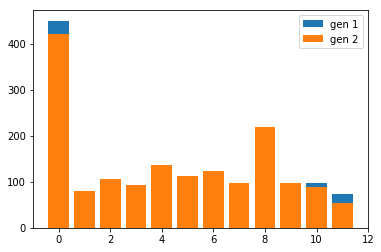

In [13]:
l_counter_1 = np.zeros(nb_outputs)
l_counter_2 = np.zeros(nb_outputs)

for x_data, y_data in from_cache_generator_1():
    for i in range(x_data.shape[0]):
        l_counter_1[y_data[i]] += 1

for x_data, y_data in from_cache_generator_2():
    for i in range(x_data.shape[0]):
        l_counter_2[y_data[i]] += 1



plt.bar([i for i in range(12)], [l_counter_1[i] for i in range(12)], label='gen 1')
plt.bar([i for i in range(12)], [l_counter_2[i] for i in range(12)], label='gen 2')

plt.legend()
plt.show()

In [16]:
%matplotlib qt

from time import sleep
from random import randint


def show(counter_ctx=5):
    for x_data, y_data in from_cache_generator_2():
        for b in range(x_data.shape[0]):
            for f in range(100):
                img = np.reshape(x_data[b, f, :], [64, 64])

                plt.figure(0)
                plt.imshow(img, cmap='gray', vmin=0, vmax=1)
                plt.show()
                plt.title('%d - %s %s' % (
                    f, 
                    gesture_mapping[y_data[i]], 
                    '(%d)' % counter_ctx if counter_ctx > 0 else '',
                ))
                plt.pause(0.0001)
                plt.clf()

            counter_ctx -= 1
            if counter_ctx == 0:
                return

show()

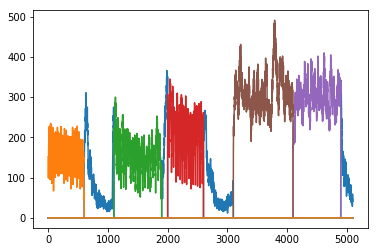

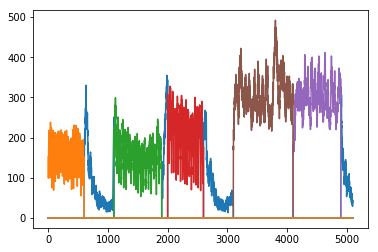

In [15]:
%matplotlib inline
from collections import defaultdict


# spike_counter = defaultdict(lambda: 0)
counter = 50

def cal_hist(gen_func):
    spike_flow = [[] for _ in range(12)]
    c = 0
    for x_data, y_data in gen_func():
        for i in range(x_data.shape[0]):
            for f in range(x_data.shape[1]):
                c_frame = x_data[i, f, :]
                spc = np.count_nonzero(c_frame)
    #             spike_counter[spc] += 1
                for l in range(12):
                    spike_flow[l].append(spc if l == y_data[i] else 0)
            if c == counter:
                return spike_flow
            else:
                c+=1
    return spike_flow




spike_flow_1 = cal_hist(from_cache_generator_1)
spike_flow_2 = cal_hist(from_cache_generator_2)    
for i in range(12):
    plt.plot(spike_flow_1[i], label='sp1 - %d' % i)
# plt.legend()
plt.show()

for i in range(12):
    plt.plot(spike_flow_2[i], label='sp2 - %d' % i)
# plt.legend()
plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


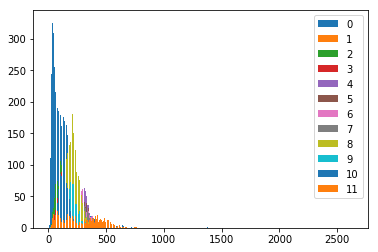

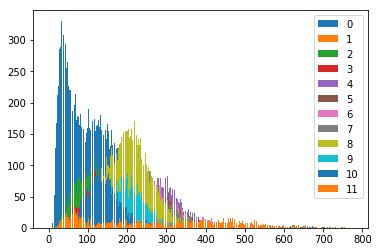

In [22]:
%matplotlib inline
from collections import defaultdict

def cal_hist_2(gen_func):
    spike_flow = [defaultdict(lambda: 0) for _ in range(12)]
    c = 0
    for x_data, y_data in gen_func():
        for i in range(x_data.shape[0]):
            for f in range(x_data.shape[1]):
                c_frame = x_data[i, f, :]
                spc = np.count_nonzero(c_frame)
                spike_flow[y_data[i]][spc] += 1
    
    for l in range(12):
        spc = spike_flow[l]
        n = max(spc)
        plt.bar([i for i in range(n)], [spc[i] for i in range(n)], label='%d' % l)
        plt.hold(True)
    plt.legend()
    plt.show()


cal_hist_2(from_cache_generator_1)
cal_hist_2(from_cache_generator_2)